In [1]:
from glob import glob
from pathlib import Path
from pydantic import BaseSettings
from matplotlib import  pyplot as plt

import cv2
import numpy as np
import rasterio
from tqdm import tqdm

In [2]:
class StatsConfig(BaseSettings):
    class Config:
        env_file = ".env"
        env_file_encoding = "utf-8"
    data_processed: Path
    subset: str = "train"

In [3]:
config = StatsConfig()
config

StatsConfig(data_processed=PosixPath('/mnt/userdata/arnaudo_data/flood-delineation'), subset='train')

In [4]:
sar_paths = sorted(list(glob(str(config.data_processed / config.subset / "*_sar.tif"))))
msk_paths = sorted(list(glob(str(config.data_processed / config.subset / "*_mask.tif"))))
assert len(sar_paths) > 0 and len(sar_paths) == len(msk_paths), "Length mismatch between SAR and masks"

In [5]:
count = 0
area = 512 * 512
ratios = list()

for sar_path, msk_path in tqdm(list(zip(sar_paths, msk_paths))):
    sar_name = Path(sar_path).stem
    msk_name = Path(msk_path).stem
    assert sar_name.split("_")[0] == msk_name.split("_")[0], "Image ID not matching"

    # read images
    with rasterio.open(str(sar_path), "r", driver="GTiff") as src:
        image = src.read().transpose(1, 2, 0)
    with rasterio.open(str(msk_path), "r", driver="GTiff") as src:
        mask = src.read().transpose(1, 2, 0)
    # deal with completely empty images
    empty = np.count_nonzero(np.isnan(image))
    if empty / float(area) >= 0.75:
        count += 1
    else:
        values, counts = np.unique(mask,return_counts=True)
        valid_portion = 0.0 if len(counts) == 1 else (counts[1] / float(area))
        ratios.append((sar_path, msk_path, valid_portion))

print(f"with nan: {count} ({float(count) / len(sar_paths) * 100.0:.2f})")

100%|██████████| 6181/6181 [01:23<00:00, 74.02it/s]

with nan: 0 (0.00)


In [6]:
sorted_sars = sorted(ratios, key=lambda x: x[-1])

<AxesSubplot:ylabel='Count'>

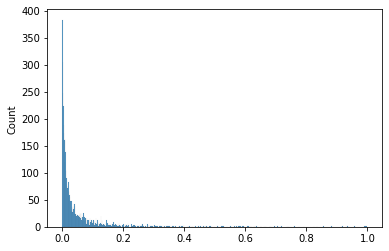

In [7]:
import seaborn as sns

sns.histplot(np.array([x[-1] for x in sorted_sars if x[-1] > 0]),bins=1000)

In [8]:
def imread(path: Path) -> np.ndarray:
    with rasterio.open(str(path), mode="r", driver="GTiff") as dataset:
        return dataset.read().transpose(1, 2, 0)

In [9]:
def log(array: np.ndarray) -> np.ndarray:
    return np.maximum(np.zeros_like(array), np.log(array + 1e-6) * 0.21714724095 + 1)

In [10]:
def rgb_ratio(raw_sar: np.ndarray) -> np.ndarray:
    #raw_sar = log(raw_sar)
    vv = raw_sar[:,:,0]
    vh = raw_sar[:,:,1]
    r = vv / 0.28
    g = vh / 0.06
    b = vh / (vv + 1e-6) / 0.49
    rgb = np.stack((r, g, b), axis=-1)
    return np.clip(rgb, 0, 1)
    #return (rgb - rgb.min()) / (rgb.max() - rgb.min())

In [11]:
def plot_group(sar_path: Path, mask_path: Path, *args, **kwargs):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    sar = imread(sar_path)
    axes[0].imshow(rgb_ratio(sar))
    axes[1].imshow(imread(mask_path))
    plt.show()

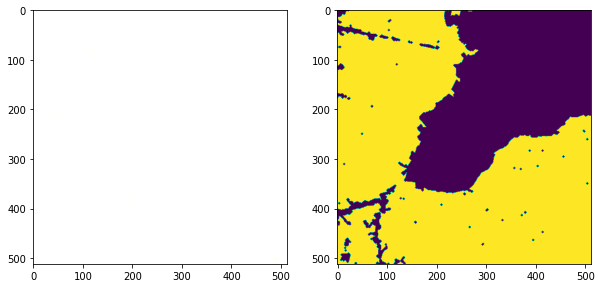

In [12]:
plot_group(*sorted_sars[-45])

In [13]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask.astype(np.uint8)

In [15]:
kernel_a = create_circular_mask(7, 7)
kernel_b = create_circular_mask(5, 5)

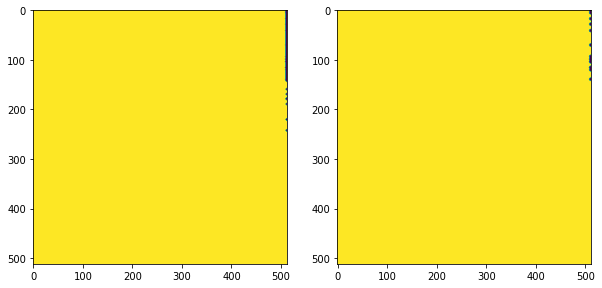

In [17]:
mask = imread(sorted_sars[-1][1])

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sar = imread(sar_path)
axes[0].imshow(mask)
m1 = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel_b)
m2 = cv2.morphologyEx(m1, cv2.MORPH_CLOSE, kernel_a)
axes[1].imshow(m2)
plt.show()